In [54]:
import json
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
results_dir = "results" #"../../results"

advbench_path = "../data/advbench/harmful_behaviors.csv"
advbench_df = pd.read_csv(advbench_path)

In [55]:
def get_files_data(files, method, outer_dir, smooth_asr=True, best_loss=True):
    data_dict = {}
    for file in files:
        with open(os.path.join(outer_dir, method, file), "r") as f:
            asr_per_step_arr = []
            loss_per_step_arr = []
            data_list = []
            try:
                data = json.load(f)
            except:
                print("ERROR in", method, file)
            
            params = data["params"]
            goals = params["goals"]
            step_num = params["n_steps"]
            controls = data["controls"]
            tests = data["tests"]
            losses = data["losses"]
            tmp_asr = []
            tmp_loss = []
            prev_goal = None
            for i, test in enumerate(tests):
                cur_goal = list(test.keys())[0]
                # check if finished prompt (moved to next goal)
                if prev_goal and cur_goal != prev_goal:
                    # add prev_goal's index in advbench_df to data_list
                    data_list.append(advbench_df[advbench_df["goal"] == prev_goal].index[0])
                    asr_per_step_arr.append(tmp_asr)
                    loss_per_step_arr.append(tmp_loss)
                    tmp_asr = []
                    tmp_loss = []

                n_passed = test["n_passed"][0]
                n_total = test["total"][0]
                n_loss = test["n_loss"][0] if not best_loss else losses[i]
                tmp_asr.append(n_passed/n_total)
                tmp_loss.append(n_loss)
                prev_goal = cur_goal

        # need to add last one
        data_list.append(advbench_df[advbench_df["goal"] == cur_goal].index[0])
        asr_per_step_arr.append(tmp_asr)
        loss_per_step_arr.append(tmp_loss)

        # make all arrays the same length (early stopping means that they succeed in all next steps)
        max_arr_len = max(len(arr) for arr in asr_per_step_arr)
        for i in range(len(asr_per_step_arr)):
            asr_per_step_arr[i] += [1] * (max_arr_len - len(asr_per_step_arr[i]))
            loss_per_step_arr[i] += [loss_per_step_arr[i][-1]] * (max_arr_len - len(loss_per_step_arr[i]))

        # make the arrays length of steps (add)
        for i in range(len(asr_per_step_arr)):
            asr_per_step_arr[i] += [1] * (step_num - len(asr_per_step_arr[i]))
            loss_per_step_arr[i] += [loss_per_step_arr[i][-1]] * (step_num - len(loss_per_step_arr[i]))

        # make the arrays length of steps (remove)
        for i in range(len(asr_per_step_arr)):
            asr_per_step_arr[i] = asr_per_step_arr[i][:step_num]
            loss_per_step_arr[i] = loss_per_step_arr[i][:step_num]

        asr_per_step_arr = np.array(asr_per_step_arr)
        loss_per_step_arr = np.array(loss_per_step_arr)


        # smooth asr (if success in step i, then success in all next steps)
        if smooth_asr:
            for i in range(asr_per_step_arr.shape[0]):
                for j in range(asr_per_step_arr.shape[1]):
                    if asr_per_step_arr[i][j] == 1:
                        asr_per_step_arr[i][j:] = 1
                        break

        model = file.split('_')[0]
        training_data = file.split('_')[4] + 'to' + file.split('_')[5]
        # skip our rebuttle for now
        if training_data == "0to0":
            continue
        key = method + "_" + file
        final_control = controls[-1]
        data_dict[key] = { "asr_per_step_arr": asr_per_step_arr, 
                            "loss_per_step_arr": loss_per_step_arr, 
                            "data_used": data_list,
                            "experiment_identifier": model + "_" + training_data + "_" + method,
                            "model": model,
                            "final_control": final_control,
                            }
    return data_dict

In [56]:
individual_dir = os.path.join(results_dir, "individual")
gcg_files = os.listdir(os.path.join(individual_dir, "GCG")) if os.path.exists(os.path.join(individual_dir, "GCG")) else []
random_files = os.listdir(os.path.join(individual_dir, "Random")) if os.path.exists(os.path.join(individual_dir, "Random")) else []
upa_files = os.listdir(os.path.join(individual_dir, "UPA")) if os.path.exists(os.path.join(individual_dir, "UPA")) else []
ipa_files = os.listdir(os.path.join(individual_dir, "IPA")) if os.path.exists(os.path.join(individual_dir, "IPA")) else []
print(f'Random: {random_files}\nGCG: {gcg_files}\nUPA: {upa_files}\nIPA: {ipa_files}')

Random: ['Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_25_125_controlSize20.json', 'vicuna-7b-v1.3_to_vicuna-7b-v1.3_trn_0_25_tst_25_125_controlSize20.json', 'Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_100_125_controlSize20.json', 'Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_56_75_controlSize20.json', 'Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_75_100_controlSize20.json']
GCG: ['Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_25_125_controlSize20.json', 'vicuna-7b-v1.3_to_vicuna-7b-v1.3_trn_0_25_tst_25_75_controlSize20.json', 'vicuna-7b-v1.3_to_vicuna-7b-v1.3_trn_0_25_tst_75_125_controlSize20.json']
UPA: ['Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_25_125_controlSize20.json', 'vicuna-7b-v1.3_to_vicuna-7b-v1.3_trn_0_25_tst_25_125_controlSize20.json']
IPA: ['Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_25_125_controlSize20.json', 'vicuna-7b-v1.3_to_vicuna-7b-v1.3_trn_0_25_tst_25_125_controlSize20.json']


In [57]:
gcg_data = get_files_data(gcg_files, "GCG", outer_dir=individual_dir, best_loss=False)
random_data = get_files_data(random_files, "Random", outer_dir=individual_dir, best_loss=False)
upa_data = get_files_data(upa_files, "UPA", outer_dir=individual_dir, best_loss=False)
ipa_data = get_files_data(ipa_files, "IPA", outer_dir=individual_dir, best_loss=False)

all_data = {**random_data, **gcg_data, **upa_data, **ipa_data}

In [58]:
#SETUP
LINE_WIDTH = 3
SMALL_SIZE = 15
SMALLER_SIZE = 12
MEDIUM_SIZE = 22
BIG_SIZE = 20
BIGGER_SIZE = 25
ALPHA = 0.3

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIG_SIZE)  # legend fontsize
plt.rc('figure', titlesize=SMALLER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.axisbelow'] = True

'''cm=plt.get_cmap('CMRmap')
NUM_COLORS = len(all_papers)+1
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)][::-1]'''
# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
colors = [(0, 0, 0), 
          (230, 25, 75), 
          (60, 180, 75), 
          (0, 130, 200), 
          (245, 130, 48),
          (128, 0, 0),
          (0, 100, 100), 
          (240, 50, 230), 
          (255, 200, 0),
          (0, 0, 128), 
          #special colors:
          (255, 255, 255), 
          (128, 128, 128),
          #seemingly bad:
          (250, 190, 190),  
          (128, 128, 0), 
          (255, 215, 180),
          (170, 255, 195), 
          (170, 110, 40), 
          (255, 250, 200), 
          (250, 190, 212),  
          (220, 190, 255), 
          (70, 240, 240), 
          (255, 250, 200),
          (170, 255, 195),
         ] 
colors = [[x[0]/255., x[1]/255., x[2]/255.] for x in colors]

colors_d = [[x[0]*0.75, x[1]*0.75, x[2]*0.75] for x in colors]
#Draw the plots without  marker
markers = ['s','D','h','>','o','p','*','x','+']

def plot_asr(asr_list, label_list, model_name, convert_to_percent=True, no_y_axis=True, max_steps=501):
    """
        asr_list: list of asr arrays to plot
        label_list: list of labels for each asr array (UPA, IPA, Random, Regular)
    """
    # order the lists according to this order of labels (when exists): Standard, Random, CRI, U-CRI
    sorted_idx = [label_list.index("Standard"), label_list.index("Random"), label_list.index("CRI (ours)"), label_list.index("U-CRI (ours)")]
    asr_list = [asr_list[i] for i in sorted_idx]
    label_list = [label_list[i] for i in sorted_idx]

    if "Llama-2" in model_name:
        model_name = "Llama-2"
        no_y_axis = False
    elif "Llama-3" in model_name:
        model_name = "Llama-3"
    elif "vicuna" in model_name:
        model_name = "Vicuna"

    fig = plt.figure(figsize=(9,6), dpi=600)
    if no_y_axis:
        plt.axes().get_yaxis().set_visible(False)
    for i, asr in enumerate(asr_list):
        steps_list = [i for i in range(max_steps)]
        # convert to percentage (ONLY IF NEEDED)
        if convert_to_percent:
            asr = [x*100 for x in asr]
        label = label_list[i]
        color = colors[0]
        if label == "Random":
            color = colors[3]
        elif label == "Standard":
            color = colors[4]
        elif label == "CRI (ours)":
            color = colors[1]
        elif label == "U-CRI (ours)":
            color = colors[2]
        # add clean asr at step 0 (0)
        asr = [0]*(max_steps - len(asr)) + asr
        plt.plot(steps_list, asr, color=color, linewidth=LINE_WIDTH, label=label)


    plt.ylim(0,100)
    plt.xlim(0, max_steps)
    plt.xlabel("Number of Steps")
    plt.ylabel("Adversarial Success Rate (ASR) [%]")
    plt.title("ASR V.S. Steps, " + model_name)
    plt.grid(axis='x')

    plt.legend()
    # if plots/ folder exists, save the plot there, otherwise create it
    if not os.path.exists("plots/"):
        os.makedirs("plots/")
    # save the plot as pdf
    file_name = f"plots/{model_name}_gcg_asr.pdf"
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()


def plot_loss(loss_list, label_list, model_name, no_y_axis=True, max_steps=500):
    """
        loss_list: list of loss arrays to plot
        label_list: list of labels for each loss array (UPA, IPA, Random, Regular)
    """
    # order the lists according to this order of labels (when exists): Standard, Random, CRI, U-CRI
    sorted_idx = [label_list.index("Standard"), label_list.index("Random"), label_list.index("CRI (ours)"), label_list.index("U-CRI (ours)")]
    loss_list = [loss_list[i] for i in sorted_idx]
    label_list = [label_list[i] for i in sorted_idx]

    if "Llama-2" in model_name:
        model_name = "Llama-2"
        no_y_axis = False
    elif "Llama-3" in model_name:
        model_name = "Llama-3"
    elif "vicuna" in model_name:
        model_name = "Vicuna"


    fig = plt.figure(figsize=(9,6), dpi=600)
    if no_y_axis:
        plt.axes().get_yaxis().set_visible(False)
    for i, loss in enumerate(loss_list):
        steps_list = [i for i in range(len(loss))]
        label = label_list[i]
        color = colors[0]
        if label == "Random":
            color = colors[3]
        elif label == "Standard":
            color = colors[4]
        elif label == "CRI (ours)":
            color = colors[1]
        elif label == "U-CRI (ours)":
            color = colors[2]
        plt.plot(steps_list, loss, color=color, linewidth=LINE_WIDTH, label=label)

    plt.xlim(0, max_steps)
    plt.xlabel("Number of Steps")
    plt.ylabel("Mean Loss")
    plt.title("Mean Loss V.S. Steps, " + model_name)
    plt.grid(axis='x')

    plt.legend()
    # if plots/ folder exists, save the plot there, otherwise create it
    if not os.path.exists("plots/"):
        os.makedirs("plots/")
    # save the plot as pdf
    file_name = f"plots/{model_name}_gcg_loss.pdf"
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

In [59]:
def plot_data(all_data, print_final_control=False, show_loss=True):
    # first, group by experiment_identifier
    grouped_data = {}
    for file, data in all_data.items():
        experiment_identifier = data["experiment_identifier"]
        if experiment_identifier not in grouped_data:
            grouped_data[experiment_identifier] = []
        grouped_data[experiment_identifier].append(data)

    # first, combine all data for each experiment_identifier
    combined_data = {}
    for experiment_identifier, data_list in grouped_data.items():
        asr_per_step_arr = []
        loss_per_step_arr = []
        data_used = []
        for data in data_list:
            for i in range(len(data["asr_per_step_arr"])):
                asr = data["asr_per_step_arr"][i]
                loss = data["loss_per_step_arr"][i]
                data_point = data["data_used"][i]

                # if IPA or Random skip first step (it is original init)
                if "IPA" in experiment_identifier or "Random" in experiment_identifier:
                    asr = asr[1:]
                    loss = loss[1:]

                if data_point not in data_used:
                    data_used.append(data_point)
                    asr_per_step_arr.append(asr)
                    loss_per_step_arr.append(loss) 
        model = data_list[0]["model"]
        final_control = data_list[0]["final_control"]
        combined_data[experiment_identifier] = {"asr_per_step_arr": asr_per_step_arr, "loss_per_step_arr": loss_per_step_arr, "data_used": data_used, "model": model, "final_control": final_control}

    # then, calc ASR and mean loss for each experiment_identifier
    asr_per_step = {}
    mean_loss_per_step = {}
    model_2_experiment_identifiers = {}
    experiment_identifier_2_data_used = {}
    experiment_identifier_2_metrics = {}
    for experiment_identifier, data in combined_data.items():
        asr_arr = data["asr_per_step_arr"]
        loss_arr = data["loss_per_step_arr"]
        asr_per_step[experiment_identifier] = np.mean(asr_arr, axis=0)
        mean_loss_per_step[experiment_identifier] = np.mean(loss_arr, axis=0)

        # Metrics
        # final ASR
        final_asr = asr_per_step[experiment_identifier][-1]
        # Median Steps to reach Success (from those that reach success)
        median_steps_to_asr = np.median([np.argmax(asr >= 1) for asr in asr_arr if 1 in asr])
        # Mean Steps to reach Success (from those that reach success)
        mean_steps_to_asr = np.mean([np.argmax(asr >= 1) for asr in asr_arr if 1 in asr])
        # mean Loss on First Step
        mean_loss_on_first_step = np.mean([loss[0] for loss in loss_arr])
        

        model = data["model"]
        if model not in model_2_experiment_identifiers:
            model_2_experiment_identifiers[model] = []
        model_2_experiment_identifiers[model].append(experiment_identifier)
        experiment_identifier_2_data_used[experiment_identifier] = data["data_used"]
        experiment_identifier_2_metrics[experiment_identifier] = {"final_asr": final_asr, "median_steps_to_asr": median_steps_to_asr, "mean_steps_to_asr": mean_steps_to_asr, "mean_loss_on_first_step": mean_loss_on_first_step}
        if print_final_control:
            print(f"{experiment_identifier}: {data['final_control']}")
    # then, plot ASRs in one fig for each model (all experiment_identifiers)
    for model in model_2_experiment_identifiers.keys():
        asr_list = []
        loss_list = []
        label_list = []
        for experiment_identifier in model_2_experiment_identifiers[model]:
            data_used = experiment_identifier_2_data_used[experiment_identifier]
            asr = asr_per_step[experiment_identifier]
            loss = mean_loss_per_step[experiment_identifier]
            method = experiment_identifier.split('_')[-1]
            if method == "GCG":
                method = "Standard"
            elif method == "IPA":
                method = "CRI (ours)"
            elif method == "UPA":
                method = "U-CRI (ours)"

            label = method #+ f" ({min(data_used)}-{max(data_used)}) - sum: {len(data_used)}"
            asr_list.append(asr)
            loss_list.append(loss)
            label_list.append(label)

            # print metrics
            metrics = experiment_identifier_2_metrics[experiment_identifier]
            print(f"{experiment_identifier}: {metrics}")

        plot_asr(asr_list, label_list, model)
        if show_loss:
            plot_loss(loss_list, label_list, model)

Llama-2-7b-chat-hf_0to25_Random: {'final_asr': 0.76, 'median_steps_to_asr': 79.0, 'mean_steps_to_asr': 113.9342105263158, 'mean_loss_on_first_step': 1.899677734375}
Llama-2-7b-chat-hf_0to25_GCG: {'final_asr': 0.9, 'median_steps_to_asr': 63.0, 'mean_steps_to_asr': 105.5111111111111, 'mean_loss_on_first_step': 2.29033203125}
Llama-2-7b-chat-hf_0to25_UPA: {'final_asr': 0.99, 'median_steps_to_asr': 0.0, 'mean_steps_to_asr': 0.6767676767676768, 'mean_loss_on_first_step': 0.334014892578125}
Llama-2-7b-chat-hf_0to25_IPA: {'final_asr': 0.97, 'median_steps_to_asr': 0.0, 'mean_steps_to_asr': 1.041237113402062, 'mean_loss_on_first_step': 0.21154315948486327}


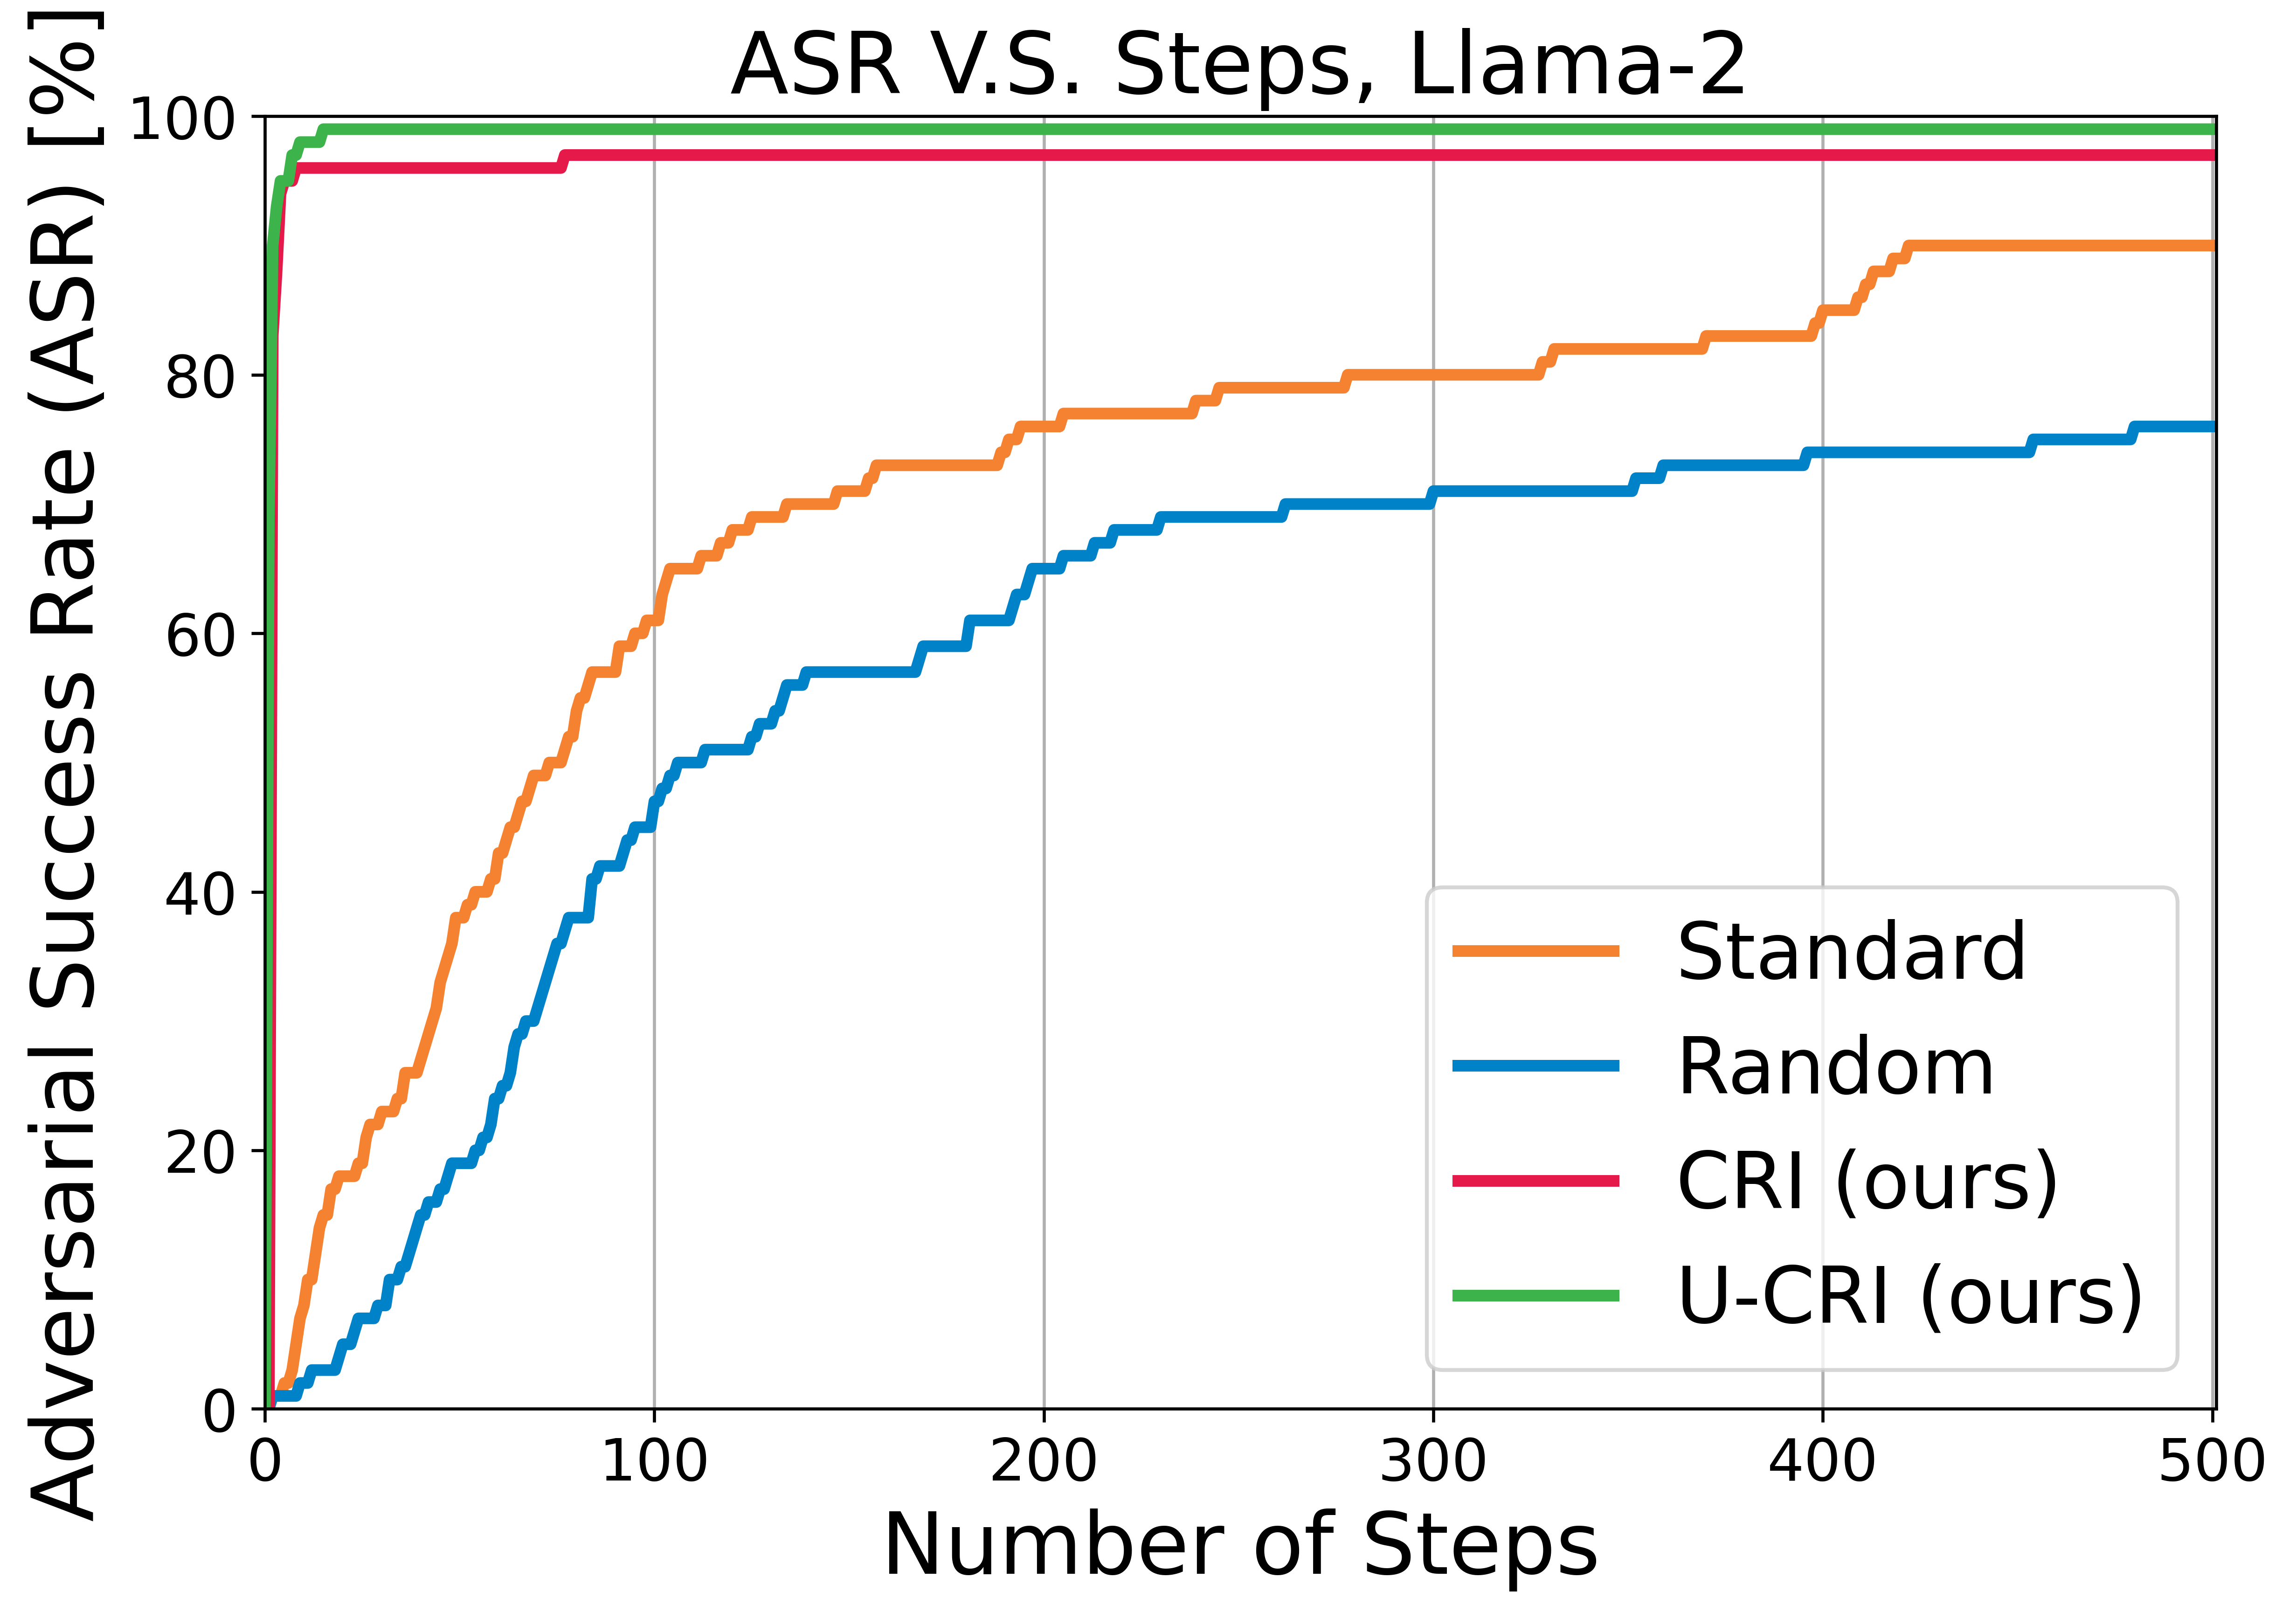

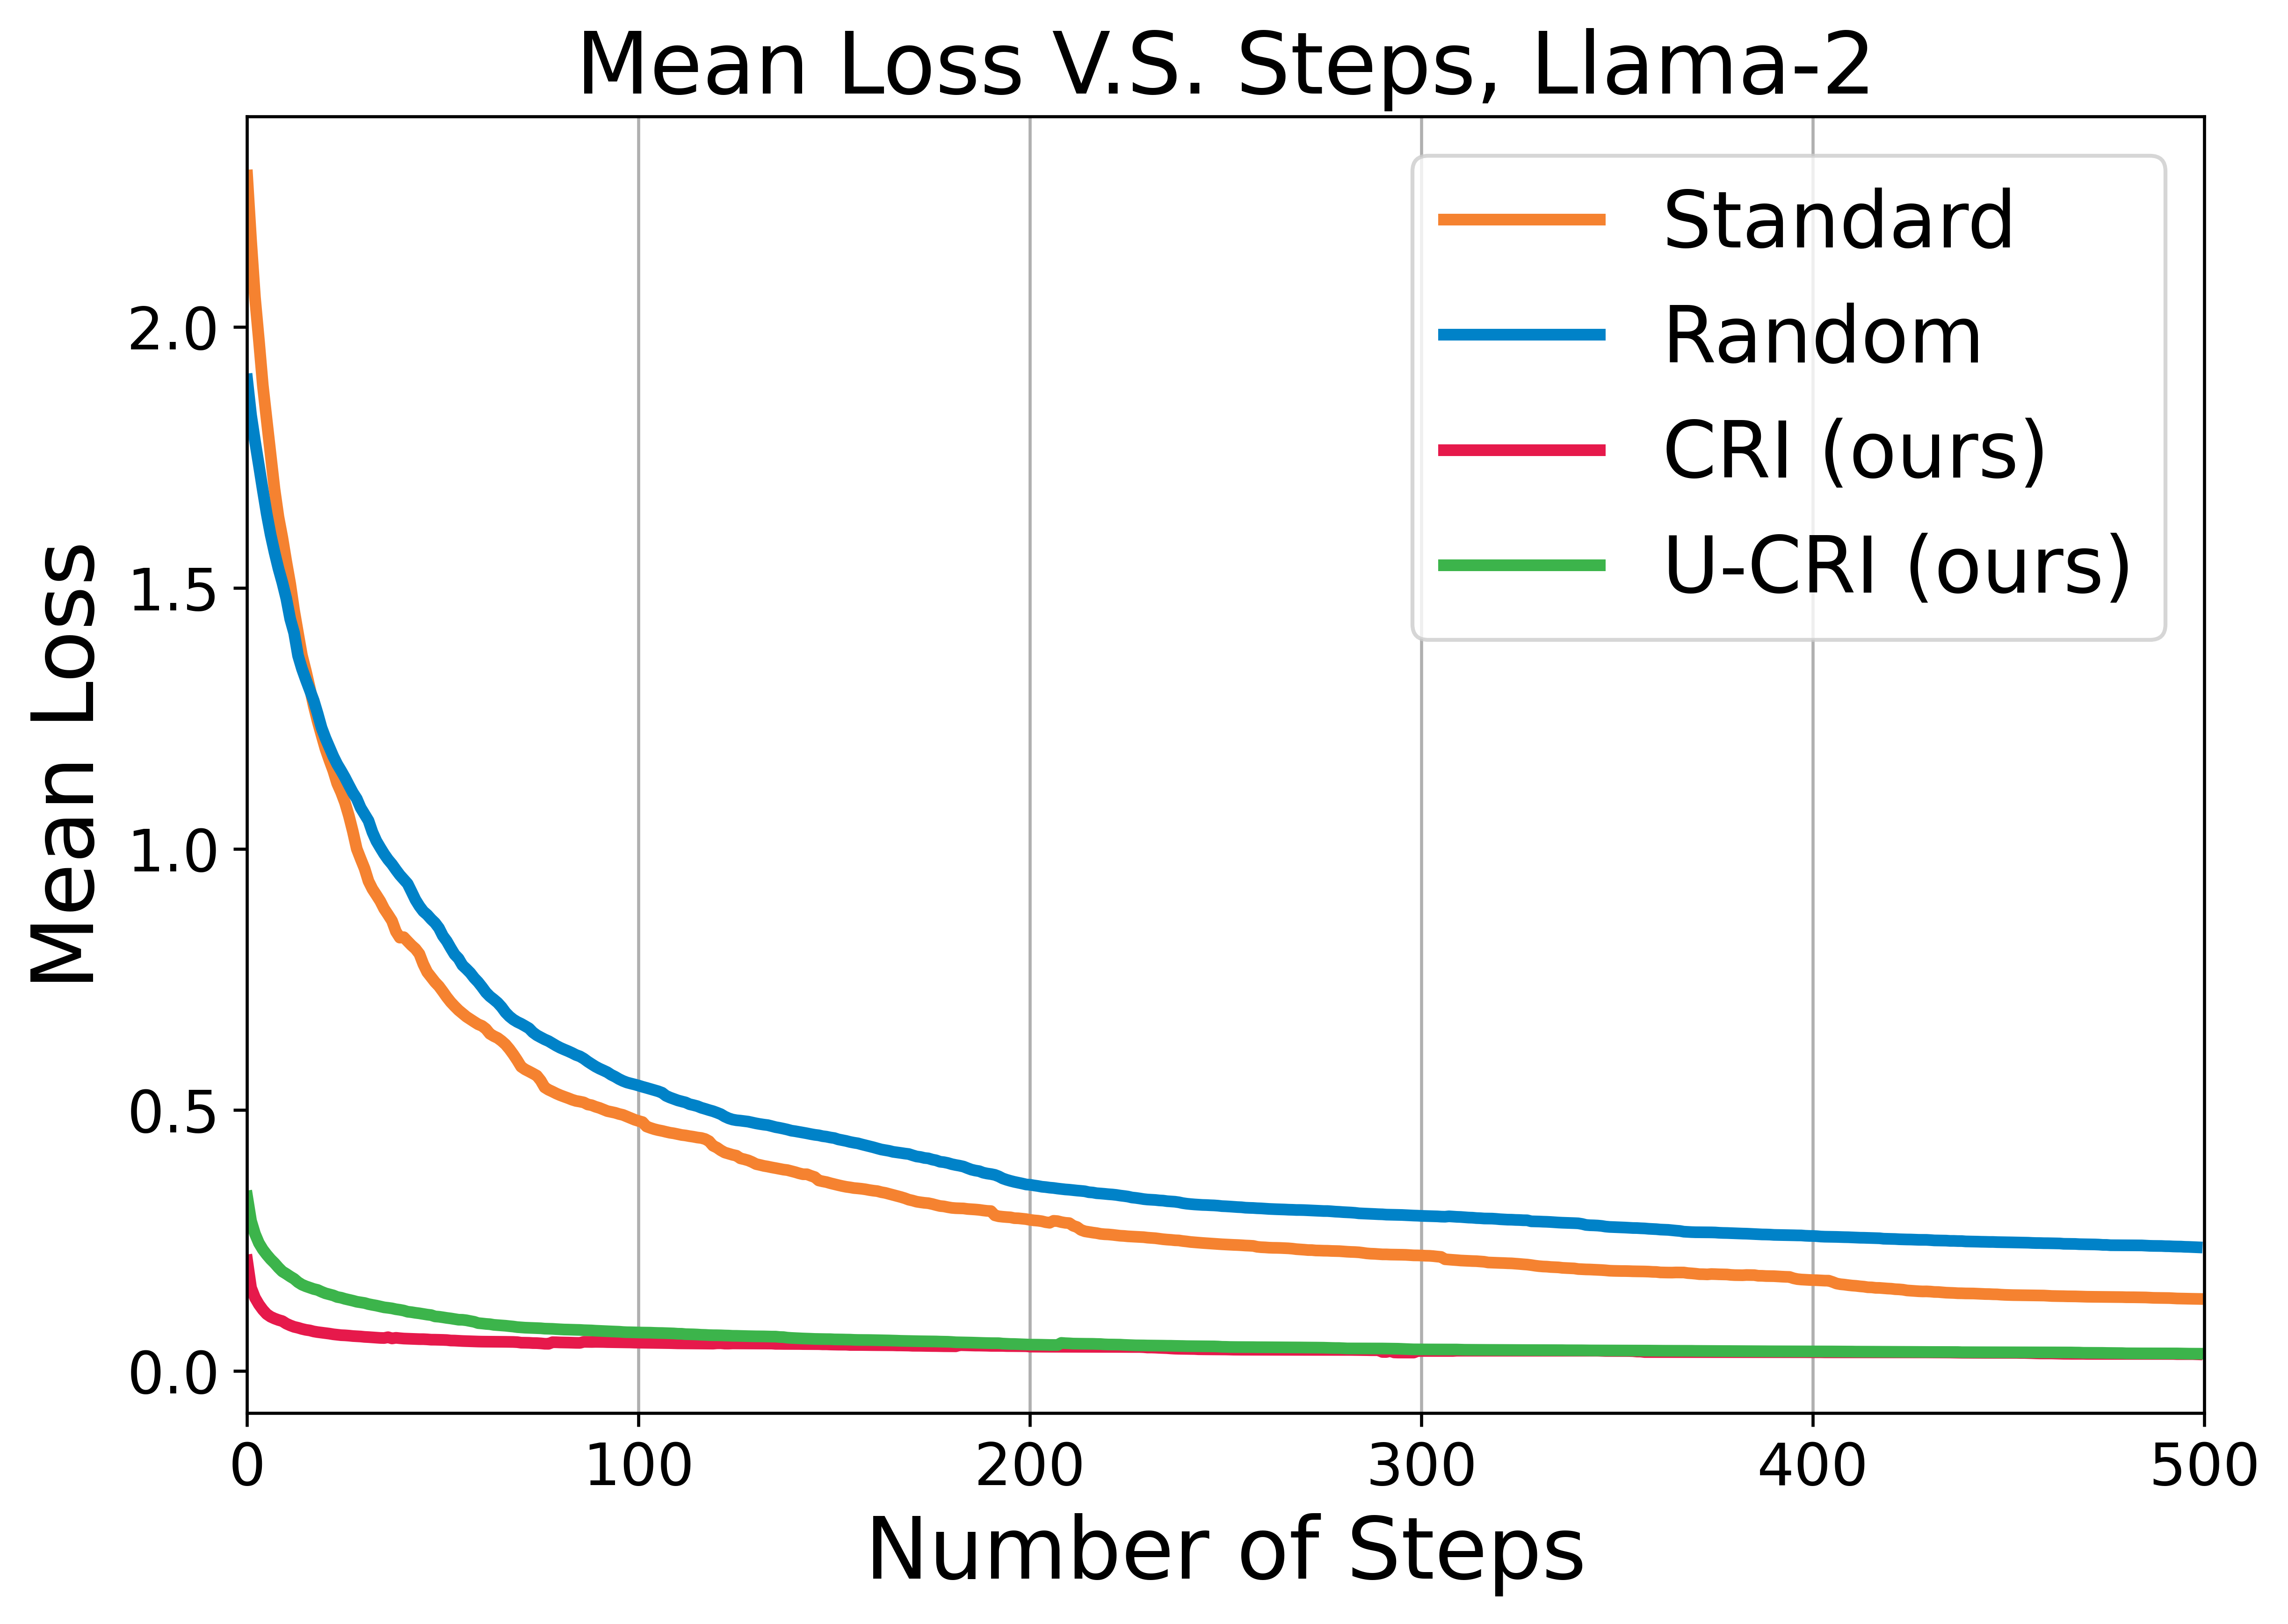

vicuna-7b-v1.3_0to25_Random: {'final_asr': 0.98, 'median_steps_to_asr': 8.0, 'mean_steps_to_asr': 14.795918367346939, 'mean_loss_on_first_step': 0.57986328125}
vicuna-7b-v1.3_0to25_GCG: {'final_asr': 0.97, 'median_steps_to_asr': 7.0, 'mean_steps_to_asr': 14.75257731958763, 'mean_loss_on_first_step': 0.798492431640625}
vicuna-7b-v1.3_0to25_UPA: {'final_asr': 0.98, 'median_steps_to_asr': 0.0, 'mean_steps_to_asr': 0.04081632653061224, 'mean_loss_on_first_step': 0.30329864501953124}
vicuna-7b-v1.3_0to25_IPA: {'final_asr': 0.97, 'median_steps_to_asr': 0.0, 'mean_steps_to_asr': 1.8350515463917525, 'mean_loss_on_first_step': 0.22758275985717774}


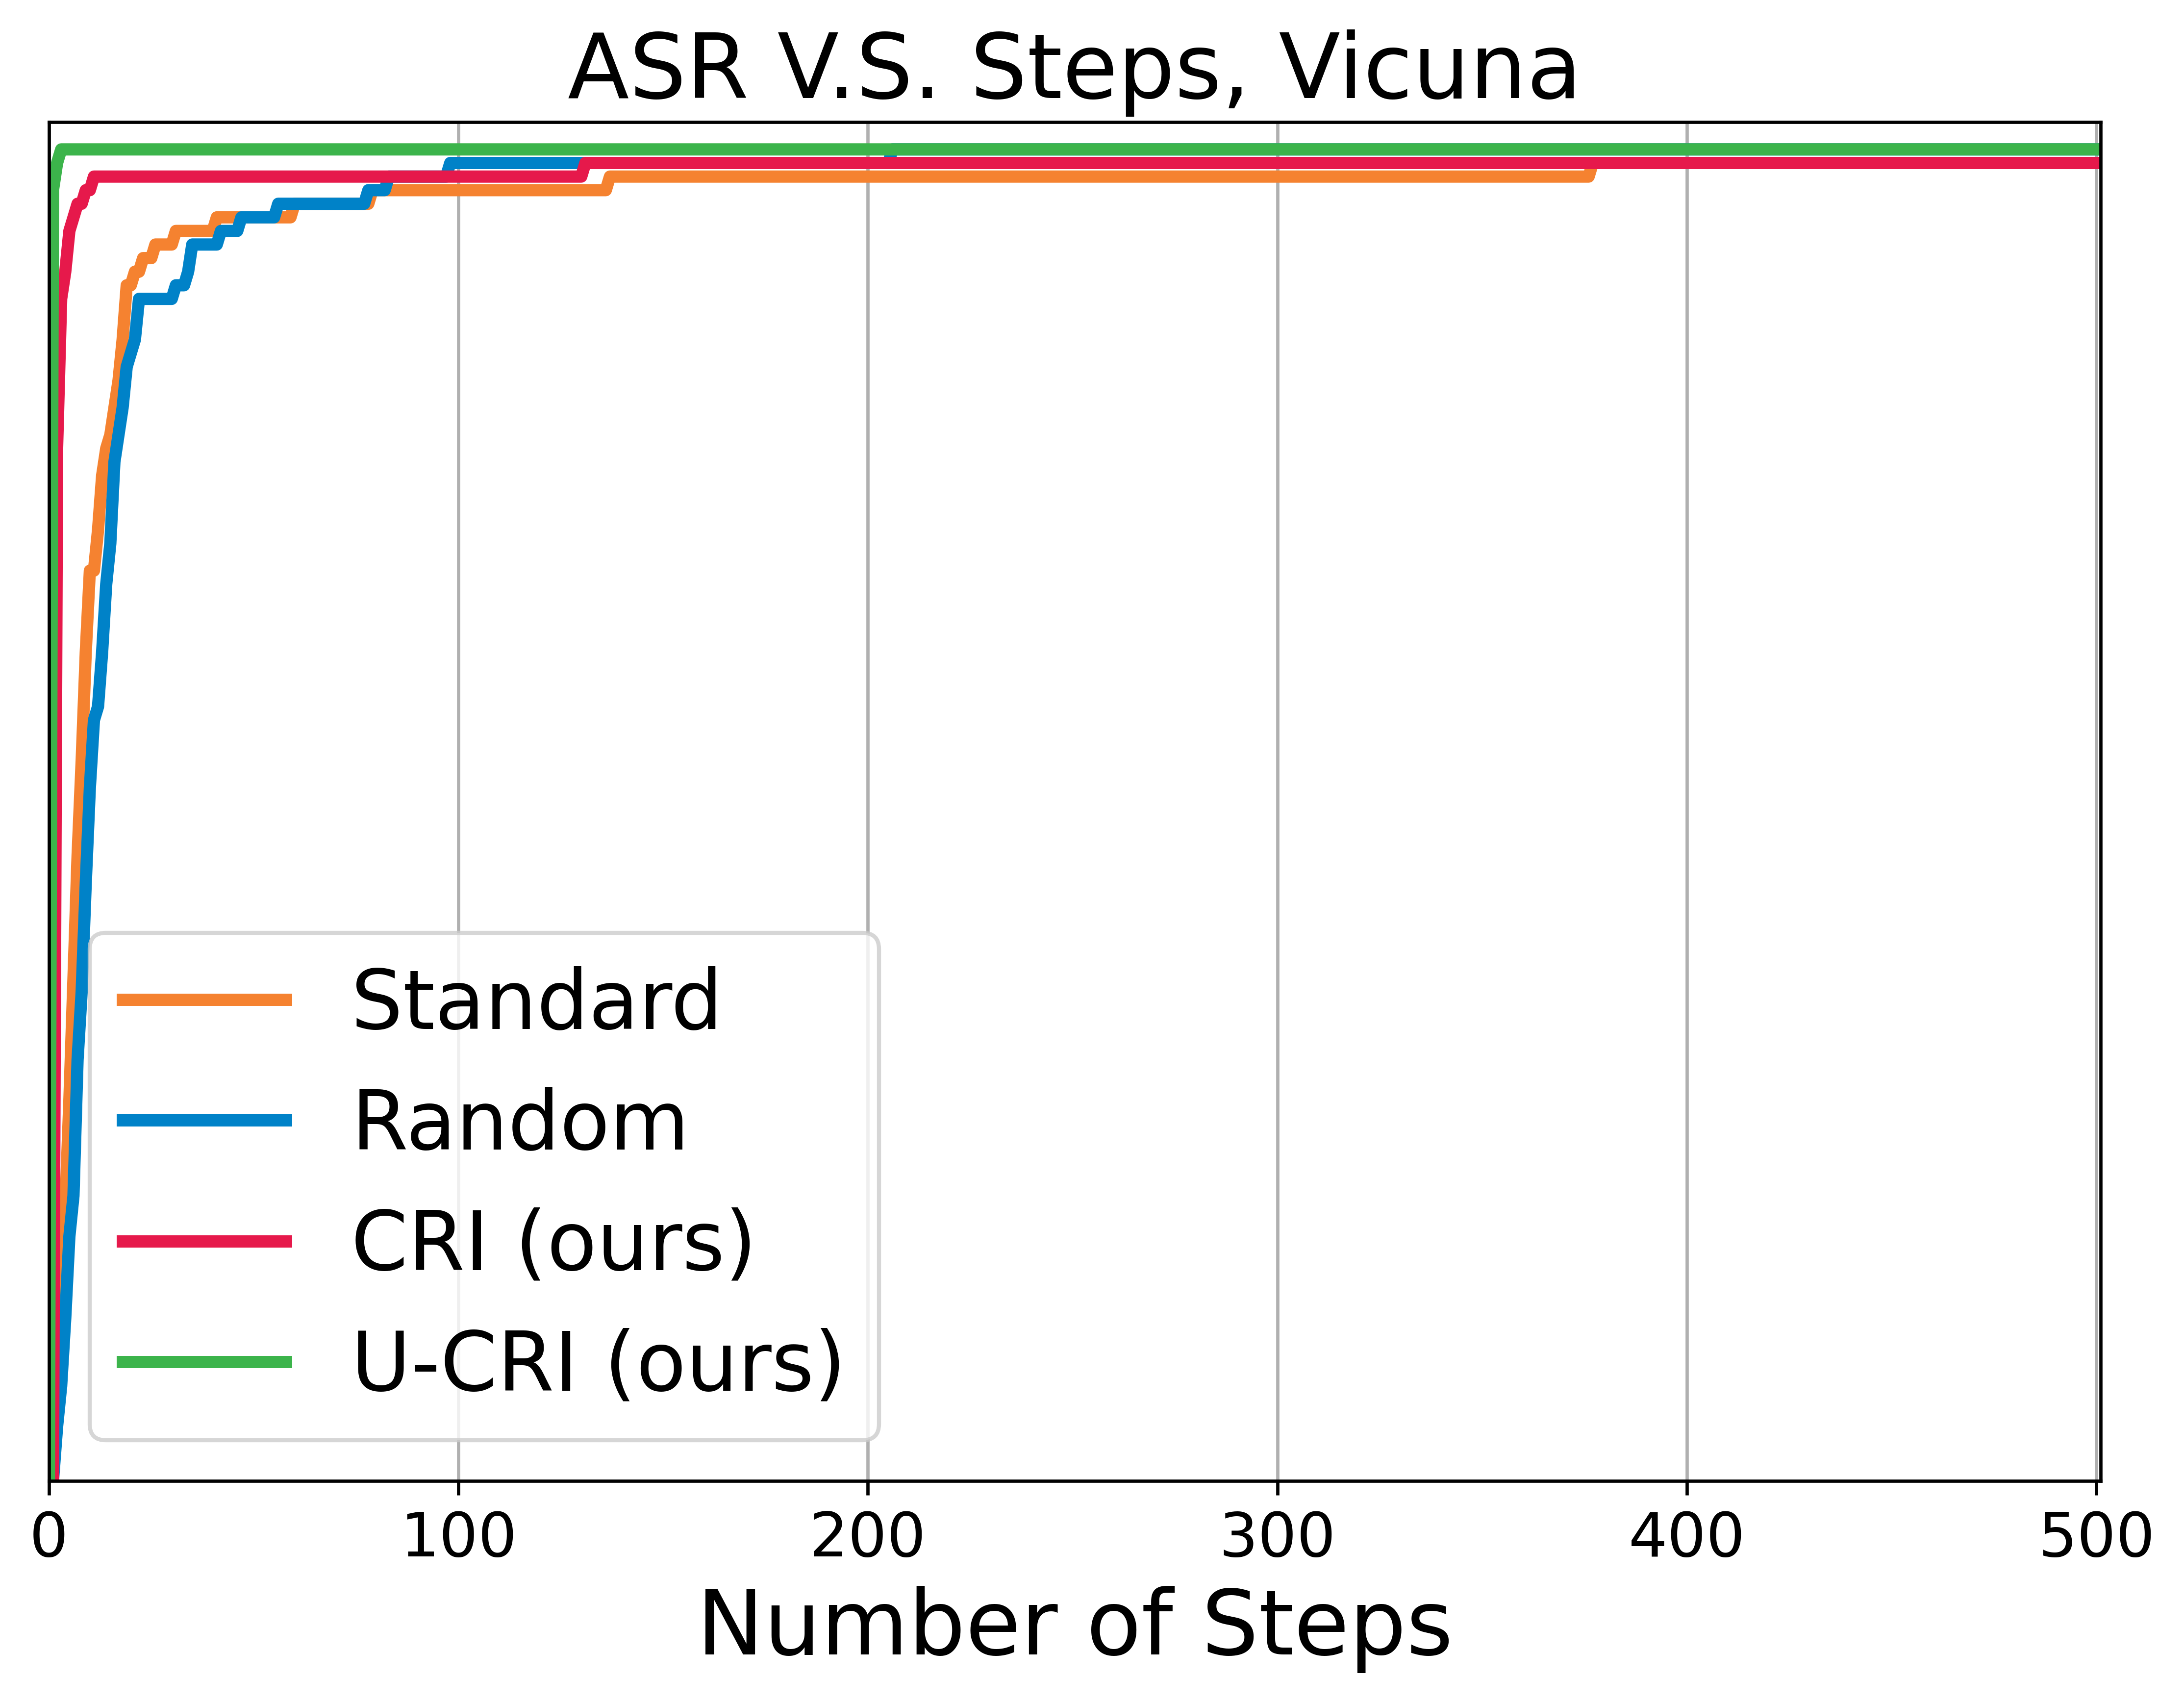

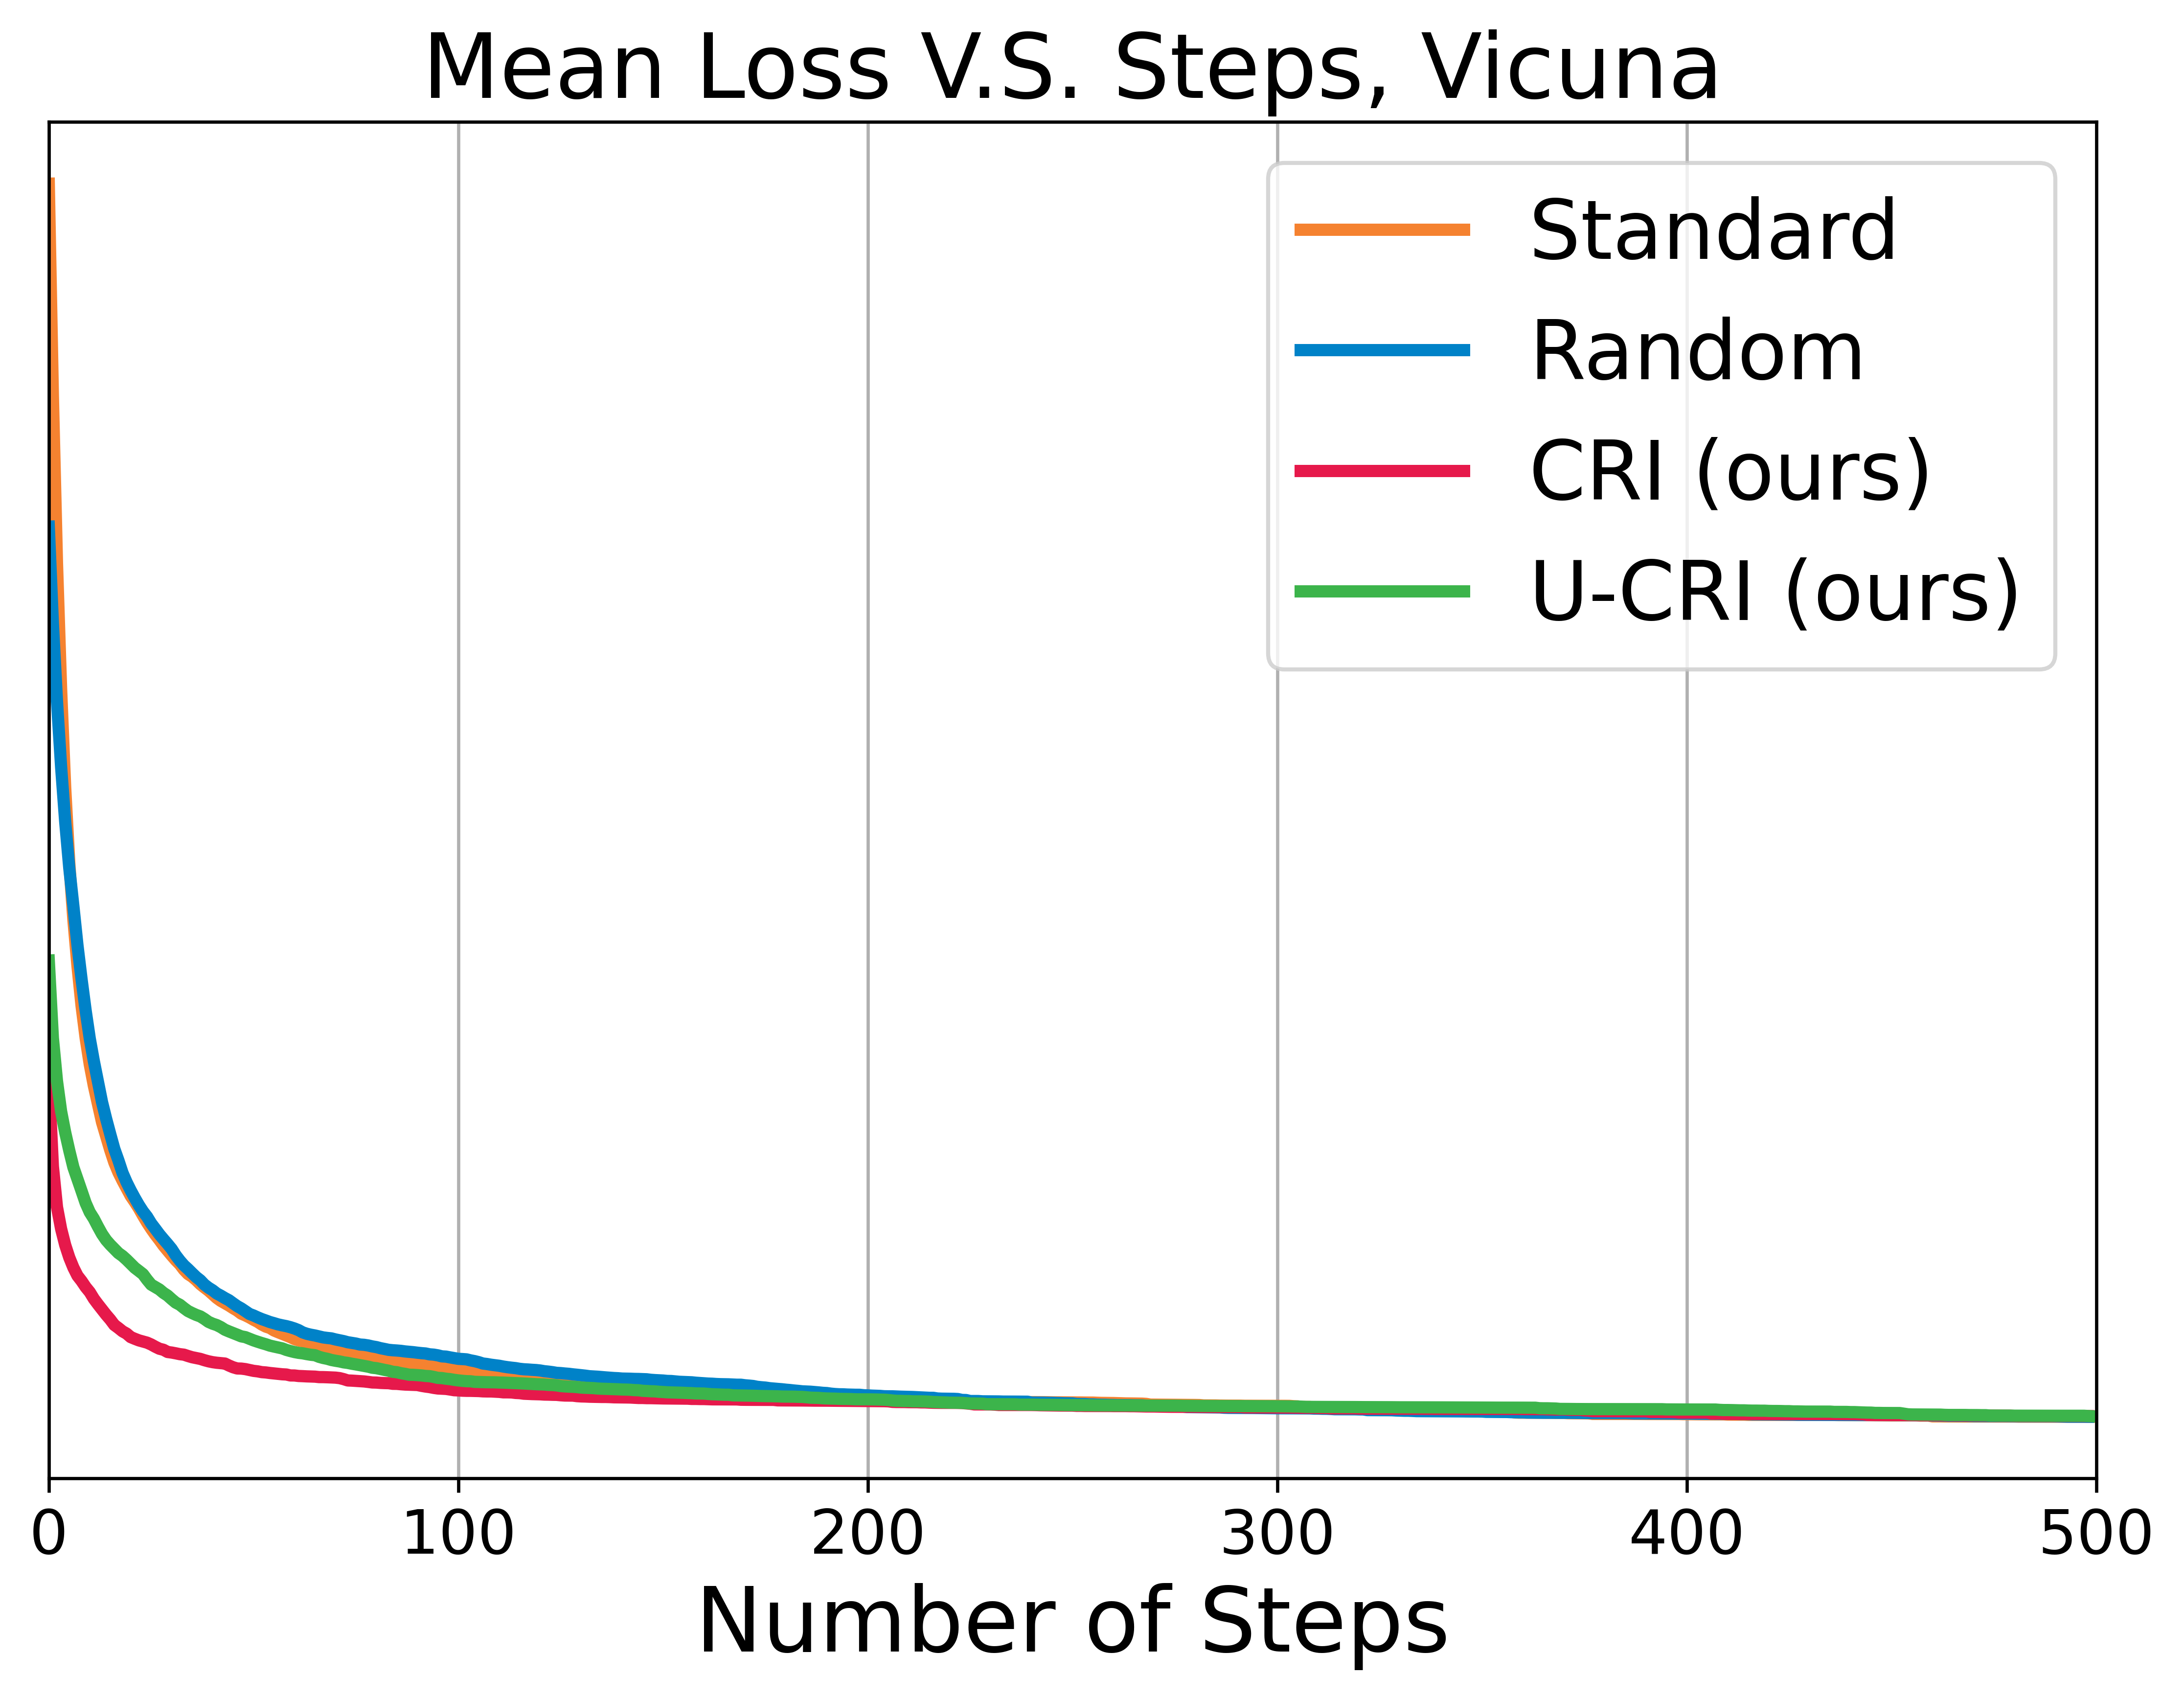

In [60]:
plot_data(all_data)

# GCG-M

In [61]:
multi_dir = os.path.join(results_dir, "transfer")
random_files = os.listdir(os.path.join(multi_dir, "Random")) if os.path.exists(os.path.join(multi_dir, "Random")) else []
gcg_files = os.listdir(os.path.join(multi_dir, "GCG")) if os.path.exists(os.path.join(multi_dir, "GCG")) else []
upa_files = os.listdir(os.path.join(multi_dir, "UPA")) if os.path.exists(os.path.join(multi_dir, "UPA")) else []
ipa_files = os.listdir(os.path.join(multi_dir, "IPA")) if os.path.exists(os.path.join(multi_dir, "IPA")) else []
print(f'Random: {random_files}\nGCG: {gcg_files}\nUPA: {upa_files}\nIPA: {ipa_files}')

Random: ['Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_25_50_controlSize20.json', 'vicuna-7b-v1.3_to_vicuna-7b-v1.3_trn_0_25_tst_25_50_controlSize20.json']
GCG: ['Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_25_50_controlSize20.json', 'vicuna-7b-v1.3_to_vicuna-7b-v1.3_trn_0_25_tst_25_50_controlSize20.json']
UPA: ['Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_25_50_controlSize20.json', 'vicuna-7b-v1.3_to_vicuna-7b-v1.3_trn_0_25_tst_25_50_controlSize20.json']
IPA: ['Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_25_50_controlSize20.json', 'vicuna-7b-v1.3_to_vicuna-7b-v1.3_trn_0_25_tst_25_50_controlSize20.json']


In [62]:
random_data = get_files_data(random_files, "Random", outer_dir=multi_dir, smooth_asr=False, best_loss=True)
gcg_data = get_files_data(gcg_files, "GCG", outer_dir=multi_dir, smooth_asr=False, best_loss=True)
upa_data = get_files_data(upa_files, "UPA", outer_dir=multi_dir, smooth_asr=False, best_loss=True)
ipa_data = get_files_data(ipa_files, "IPA", outer_dir=multi_dir, smooth_asr=False, best_loss=True)

all_data = {**random_data, **gcg_data, **upa_data, **ipa_data}

In [63]:
# plot_data(all_data)

# For Framework Figure

In [64]:
def get_files_data_for_framework(files, method, outer_dir, smooth_asr=True, best_loss=True):
    data_dict = {}
    for file in files:
        with open(os.path.join(outer_dir, method, file), "r") as f:
            asr_per_step_arr = []
            loss_per_step_arr = []
            control_per_step_arr = []
            data_list = []
            goal_list = []
            try:
                data = json.load(f)
            except:
                print("ERROR in", method, file)
            
            params = data["params"]
            goals = params["goals"]
            step_num = params["n_steps"]
            controls = data["controls"]
            tests = data["tests"]
            losses = data["losses"]
            tmp_asr = []
            tmp_loss = []
            tmp_controls = []
            prev_goal = None
            for i, test in enumerate(tests):
                cur_goal = list(test.keys())[0]
                # check if finished prompt (moved to next goal)
                if prev_goal and cur_goal != prev_goal:
                    # add prev_goal's index in advbench_df to data_list
                    data_list.append(advbench_df[advbench_df["goal"] == prev_goal].index[0])
                    asr_per_step_arr.append(tmp_asr)
                    loss_per_step_arr.append(tmp_loss)
                    control_per_step_arr.append(tmp_controls)
                    goal_list.append(prev_goal)
                    tmp_asr = []
                    tmp_loss = []
                    tmp_controls = []


                n_passed = test["n_passed"][0]
                n_total = test["total"][0]
                n_loss = test["n_loss"][0] if not best_loss else losses[i]
                tmp_asr.append(n_passed/n_total)
                tmp_loss.append(n_loss)
                tmp_controls.append(controls[i])
                prev_goal = cur_goal

        # need to add last one
        data_list.append(advbench_df[advbench_df["goal"] == cur_goal].index[0])
        asr_per_step_arr.append(tmp_asr)
        loss_per_step_arr.append(tmp_loss)
        control_per_step_arr.append(tmp_controls)
        goal_list.append(cur_goal)

        # make all arrays the same length (early stopping means that they succeed in all next steps)
        max_arr_len = max(len(arr) for arr in asr_per_step_arr)
        for i in range(len(asr_per_step_arr)):
            asr_per_step_arr[i] += [1] * (max_arr_len - len(asr_per_step_arr[i]))
            loss_per_step_arr[i] += [loss_per_step_arr[i][-1]] * (max_arr_len - len(loss_per_step_arr[i]))
            control_per_step_arr[i] += [control_per_step_arr[i][-1]] * (max_arr_len - len(control_per_step_arr[i]))

        # make the arrays length of steps (add)
        for i in range(len(asr_per_step_arr)):
            asr_per_step_arr[i] += [1] * (step_num - len(asr_per_step_arr[i]))
            loss_per_step_arr[i] += [loss_per_step_arr[i][-1]] * (step_num - len(loss_per_step_arr[i]))
            control_per_step_arr[i] += [control_per_step_arr[i][-1]] * (step_num - len(control_per_step_arr[i]))

        # make the arrays length of steps (remove)
        for i in range(len(asr_per_step_arr)):
            asr_per_step_arr[i] = asr_per_step_arr[i][:step_num]
            loss_per_step_arr[i] = loss_per_step_arr[i][:step_num]

        asr_per_step_arr = np.array(asr_per_step_arr)
        loss_per_step_arr = np.array(loss_per_step_arr)


        # smooth asr (if success in step i, then success in all next steps)
        if smooth_asr:
            for i in range(asr_per_step_arr.shape[0]):
                for j in range(asr_per_step_arr.shape[1]):
                    if asr_per_step_arr[i][j] == 1:
                        asr_per_step_arr[i][j:] = 1
                        break

        model = file.split('_')[0]
        training_data = file.split('_')[4] + 'to' + file.split('_')[5]
        # skip our rebuttle for now
        if training_data == "0to0":
            continue
        key = method + "_" + file
        final_control = controls[-1]
        data_dict[key] = { "asr_per_step_arr": asr_per_step_arr, 
                            "loss_per_step_arr": loss_per_step_arr, 
                            "control_per_step_arr": control_per_step_arr,
                            "goal_list": goal_list,
                            "data_used": data_list,
                            "experiment_identifier": model + "_" + training_data + "_" + method,
                            "model": model,
                            "final_control": final_control,
                            }
    return data_dict

In [65]:
gcg_files = os.listdir(os.path.join(individual_dir, "GCG")) if os.path.exists(os.path.join(individual_dir, "GCG")) else []
upa_files = os.listdir(os.path.join(individual_dir, "UPA")) if os.path.exists(os.path.join(individual_dir, "UPA")) else []

gcg_data = get_files_data_for_framework(gcg_files, "GCG", outer_dir=individual_dir, best_loss=False)
upa_data = get_files_data_for_framework(upa_files, "UPA", outer_dir=individual_dir, best_loss=False)

# keep only model=Llama-2-7b-chat-hf values
gcg_data = {k: v for k, v in gcg_data.items() if "Llama-2-7b-chat-hf" in k}
upa_data = {k: v for k, v in upa_data.items() if "Llama-2-7b-chat-hf" in k}

In [66]:
gcg_data.keys(), upa_data.keys()

(dict_keys(['GCG_Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_25_125_controlSize20.json']),
 dict_keys(['UPA_Llama-2-7b-chat-hf_to_Llama-2-7b-chat-hf_trn_0_25_tst_25_125_controlSize20.json']))

In [67]:
# from embedding_experiments_utils import *
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_str = "meta-llama/Llama-2-7b-chat-hf" # change model accordingly
# tokenizer, conversation_template, model = get_starting_ground(model_str, device)

In [68]:
def generate_output(goal, control, model, tokenizer, conversation_template, device, max_length=50):
    with torch.no_grad():
        prompt = prepare_prompt(conversation_template, goal, control)
        # tokenize the prompt
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        # generate the output
        output = model.generate(input_ids, max_length=input_ids.shape[1] + max_length, use_cache=False)
        output = tokenizer.decode(output[0], skip_special_tokens=True)
    output = output[len(prompt)-3:]
    return output

In [69]:
def get_first_and_first_successful_control(data_dict):
    goals = []
    first_control = []
    first_successful_control = []
    first_success_step = []
    for key, data in data_dict.items():
        asr_per_step_arr = data['asr_per_step_arr']
        control_per_step_arr = data['control_per_step_arr']
        goal_list = data['goal_list']
        for i in range(len(asr_per_step_arr)):
            asr = asr_per_step_arr[i]
            controls = control_per_step_arr[i]
            goal = goal_list[i]
            goals.append(goal)
            first_control.append(controls[0])
            first_successful_step = np.argmax(asr >= 1) + 1 if 1 in asr else None
            if 1 in asr:
                first_successful_control.append(controls[first_successful_step])
                first_success_step.append(first_successful_step)
            else:
                first_successful_control.append(None)
                first_success_step.append(None)

    return goals, first_control, first_successful_control, first_success_step

gcg_goals, gcg_first_controls, gcg_first_successful_controls, gcg_first_success_steps = get_first_and_first_successful_control(gcg_data)
upa_goals, upa_first_controls, upa_first_successful_controls, upa_first_success_steps = get_first_and_first_successful_control(upa_data)

In [70]:
# gcg_df = pd.DataFrame({'goals': gcg_goals, 'first_controls': gcg_first_controls, 'first_successful_controls': gcg_first_successful_controls, 'first_success_steps': gcg_first_success_steps})
# upa_df = pd.DataFrame({'goals': upa_goals, 'first_controls': upa_first_controls, 'first_successful_controls': upa_first_successful_controls, 'first_success_steps': upa_first_success_steps})

# # sample random index and compare gcg vs. upa
# idx = np.random.choice(gcg_df.index)
# gcg_goal = gcg_df['goals'][idx]
# upa_goal = upa_df['goals'][idx]
# gcg_first_control = gcg_df['first_controls'][idx]
# upa_first_control = upa_df['first_controls'][idx]
# gcg_first_success_step = gcg_df['first_success_steps'][idx]
# upa_first_success_step = upa_df['first_success_steps'][idx]
# gcg_first_successful_control = gcg_df['first_successful_controls'][idx]
# upa_first_successful_control = upa_df['first_successful_controls'][idx]


# # generate output for first successful control
# gcg_output = generate_output(gcg_goal, gcg_first_successful_control, model, tokenizer, conversation_template, device)
# upa_output = generate_output(upa_goal, upa_first_successful_control, model, tokenizer, conversation_template, device)

# print(f"idx: {idx}")
# print(f"GCG: {gcg_goal} {gcg_first_control} -> {gcg_first_success_step} steps -> {gcg_goal} {gcg_first_successful_control} -> {gcg_output}")
# print(f"UPA: {upa_goal} {upa_first_control} -> {upa_first_success_step} steps -> {upa_goal} {upa_first_successful_control} -> {upa_output}")